iter:50 training loss: 699.5076293945312, val loss: 699.5736083984375
iter:100 training loss: 130.7815704345703, val loss: 130.93043518066406
iter:150 training loss: 49.39470672607422, val loss: 49.64290237426758
iter:200 training loss: 25.636274337768555, val loss: 25.87879753112793
iter:250 training loss: 17.09954261779785, val loss: 17.27937889099121
iter:300 training loss: 13.428689002990723, val loss: 13.597479820251465
iter:350 training loss: 11.319491386413574, val loss: 11.481374740600586
iter:400 training loss: 9.944133758544922, val loss: 10.099468231201172
iter:450 training loss: 8.970494270324707, val loss: 9.116514205932617
iter:500 training loss: 8.251884460449219, val loss: 8.396244049072266
iter:550 training loss: 7.710432529449463, val loss: 7.855483055114746
iter:600 training loss: 7.301183700561523, val loss: 7.445988655090332
iter:650 training loss: 6.985186576843262, val loss: 7.132332801818848
iter:700 training loss: 6.739422798156738, val loss: 6.88576602935791
i

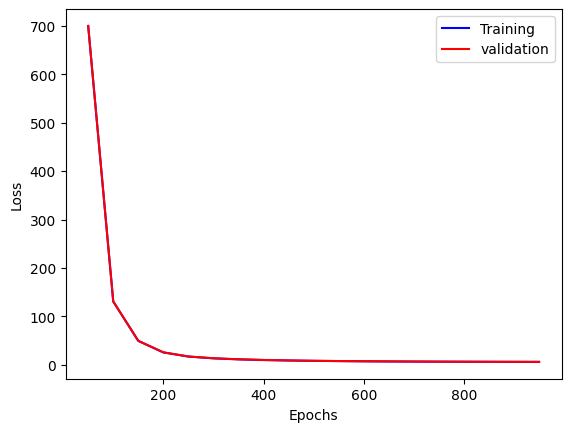

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass



@dataclass
class SAE_Config:
    input_size : int = 5
    hidden_size : int = 20
    l1_coefficient : int = 0.01


class SAE(nn.Module):
    def __init__(self, config : SAE_Config) -> None:
        super().__init__()
        self.config = config
        self.encoder = nn.Linear(config.input_size, config.hidden_size)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(config.hidden_size, config.input_size)
    
    def forward(self, input : torch.Tensor):
        input = input - self.decoder.bias
        hidden = self.encoder(input)
        hidden = self.relu(hidden)
        sparse_penalty = hidden.abs().sum()
        idx = self.decoder(hidden)

        l2_error = ((input-idx)**2).sum(-1).mean(0)

        loss = l2_error + self.config.l1_coefficient*sparse_penalty

        return idx, loss, hidden

def sample_data(split = 'train'):
    if split == 'train':
        return training_dataset
    return validation_dataset


    



import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px



learning_rate = 0.003
max_iters = 1000
batch_size = 32

iters = []
loss_value = []
val_loss_value = []

dataset = torch.load("data/hidden.pt")
dataset_size = dataset.shape[0]
training_dataset = dataset[:int(dataset_size*0.5)]
validation_dataset = dataset[int(dataset_size*0.5):]
model = SAE(SAE_Config())

LOAD_MODEL = False
PATH = "models/basic_linear_0.99.bin"
if LOAD_MODEL:
    model = SAE(SAE_Config())
    model.load_state_dict(torch.load(PATH))
    model.eval()
else:
    optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
    start_time = time.time()
    step_value = max_iters/20
    for i in range(1, max_iters):
        X= sample_data()
        _, loss,_ = model(X)
    
        if i%step_value ==0 :
            model.eval()
            with torch.no_grad():
                X_V = sample_data(split= 'val')
                _, val_loss, _ = model(X_V)
                iters.append(i)
                loss_value.append(loss.item())
                val_loss_value.append(val_loss.item())
                print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
            model.train()

        optimizer.zero_grad(set_to_none=True)
        #loss+= get_l1_penalty()
        loss.backward()
        optimizer.step()


    end_time = time.time()
    print(f"Took {end_time-start_time}s for {max_iters} epochs")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(iters,loss_value, color='blue', label="Training")
    plt.plot(iters, val_loss_value, "red", label = "validation")
    plt.legend()



        






In [80]:
_, _, hidden = model(training_dataset[:10000])

In [85]:
(hidden>0).sum(-1).sum()

tensor(128)

In [29]:
dataset.shape

torch.Size([327680, 5])

In [18]:
c.sum(-1)

tensor([2.0969, 0.4988, 0.7195, 1.4912, 1.0014, 1.7966, 0.4861, 1.4162, 0.6676,
        1.1080])

In [63]:
SAE.sample_data(split= 'val')

TypeError: SAE.sample_data() got multiple values for argument 'split'